In [148]:
# Librerias

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#python -m nltk.downloader all
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
#Librerias para el perceptron multicapa
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.neural_network import MLPClassifier
#import keras as keras
#from keras.models import Sequential
#from keras.layers import Dense, Input
import keras_tuner as kt

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

## Analisis de los datos

**Cargar los datos y separarlos**

In [95]:
# Lectura del archivo y transformación al formato DataFrrame de pandas
file = pd.read_excel('Train_textosODS.xlsx')
file.head(5)

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


Breve Exporacion de los datos

In [98]:
# Verificación de Duplicados y datos incompletos
print(f'Duplicados: {file.duplicated().sum()}')
print(f'Nulos: {file.isna().sum()}')
    # No es necesario eliminar datos ni imputar

Duplicados: 0
Nulos: textos    0
ODS       0
dtype: int64


<Axes: ylabel='count'>

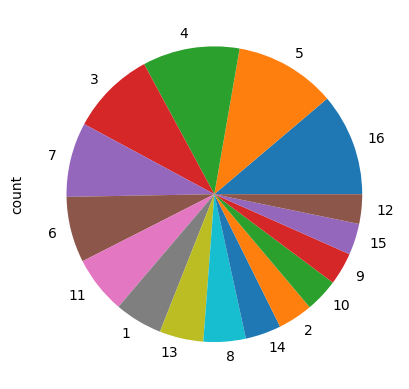

In [100]:
#Proporción de las clases
file['ODS'].value_counts().plot(kind='pie')

Como podemos observar el conjunto de datos se componen de 16 posibles categorias, de las cuales solo 5 de estas representan la mitad del conjunto de datos, por lo que se esperaria de ante mano que los modelos tiendan a predecir de mejor manera estas clases.

**Separacion de los datos entre etiquetas y datos**

In [104]:
#Separación de las variables
ODS = file['ODS']
textos = file['textos']

# 3 ejemplos de los textos a procesar
print(textos[15] + '\n<Total de palabras = ' + str(len(textos[15].split())) + '>')
print('\n' + textos[50] + '\n<Total de palabras = ' + str(len(textos[50].split()))+ '>')
print('\n' + textos[150] + '\n<Total de palabras = ' + str(len(textos[150].split()))+ '>')

Las guerras, los conflictos armados y la ocupación de territorios a menudo conducen a un aumento de la prostitución, la trata de mujeres y las agresiones sexuales a las mujeres, que requieren medidas de protección y punitivas específicas. La igualdad en el empleo puede verse gravemente afectada cuando las mujeres son objeto de violencia específica de género, como el acoso sexual en el lugar de trabajo. El acoso sexual incluye comportamiento sexualmente determinado no deseado como contacto físico y avances, comentarios de color sexual, mostrar pornografía y demanda sexual, ya sea con palabras o acciones.
<Total de palabras = 95>

También se le otorgó el monopolio de los derechos de importación sobre el arroz y la harina de trigo. A través de BIMAS, se desarrollaron y difundieron paquetes de cambio tecnológico en forma de variedades de alto rendimiento (HYV) de arroz, fertilizantes y pesticidas a precios subsidiados a través de quioscos operados por cooperativas de aldea (Koperasi Unit D

De los ejemplos podemos decir que vamos a trabajar con textos tipo parrafo con alrededor de 80 a 100 palabras cada uno.

### Clase para procesar/preparar el texto

In [108]:
class TextProcessor(BaseEstimator, TransformerMixin):
    '''
    A text processing class for text data. This transformer handles tokenization,
    stop word removal, and stemming (optional), and transforms text data into
    a bag-of-words representation.
    '''
    def __init__(self, token_cue = r'\w+', language = 'spanish', stemming_switch = True):
        self.language = language
        self.token_cue = token_cue
        self.stop_words_list = stopwords.words(self.language)
        self.tokenizer = RegexpTokenizer(self.token_cue)
        self.stemming_switch = stemming_switch
        self.stemmer = SnowballStemmer(self.language)
        self.vectorizer = TfidfVectorizer()

    def fit(self, text, y = None):
        
        if self.stemming_switch:
            processed_text = self.stemming(self.remove_stop_words(self.tokenize(text)))
        else:
            processed_text = self.remove_stop_words(self.tokenize(text))
            
        processed_text_str_lst = [' '.join(tokens) for tokens in processed_text]        
        self.vectorizer.fit(processed_text_str_lst)
        
        return self

    def tokenize(self,text):
        return text.apply(lambda x: self.tokenizer.tokenize(x))

    def remove_stop_words(self,text):
        return text.apply(lambda x: [token for token in x if token not in self.stop_words_list])

    def stemming(self,text):
        #return text.apply(lambda x: [self.stemmer.stem(token) for token in x])
        return text.apply(lambda x: [str(self.stemmer.stem(token)) for token in x])

    def BOW_transform(self,stems):
        return self.vectorizer.fit_transform(stems.apply(lambda x: ' '.join(x)))

    def transform(self, text, y=None):
        if self.stemming_switch:
            processed_text = self.stemming(self.remove_stop_words(self.tokenize(text)))
        else:
            processed_text = self.remove_stop_words(self.tokenize(text))

        # Usar el vectorizador ajustado para transformar los textos procesados
        return self.vectorizer.transform([' '.join(tokens) for tokens in processed_text])

**Dvision del set entre train y test**

In [111]:
# Separar los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(textos, ODS, test_size = 0.2, random_state=0)

## Desarrollo de los Modelos

### Regresion Logistica

**Definir el Pipeline para Regresion Logistica**

In [116]:
pipeline_logreg = Pipeline([
    ('text_processor', TextProcessor()),
    ('tsvd', TruncatedSVD(n_components=100)),
    ('logreg', LogisticRegression(max_iter=500))
])

**Buscar los mejores hiperparametros y seleccionar el mejor modelo**

In [119]:
# Encontrar los mejores hiperparametros
# no se busca el mejor penalizador ya que de antemano se desea utilizar lbfgs
# el cual no soporta otro tipo de penalizacion diferente a l2

params_logreg = {
    'text_processor__token_cue': [r'\w+', r'(\w+\s+\w+)'],  # Tokenización por palabras sencillas y por pares de palabras
    'tsvd__n_components': [75,85,100],                      # Reducción de la dimensionalidad
    'logreg__C': [0.5, 1, 5]                            # Regularización para la regresión logística
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = RandomizedSearchCV(pipeline_logreg, param_distributions = params_logreg, n_iter = 5, cv=kfold, scoring='accuracy', random_state=42, verbose = 3)
grid.fit(X_train, y_train)
best_logreg = grid.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=75;, score=0.823 total time=  10.6s
[CV 2/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=75;, score=0.808 total time=  10.3s
[CV 3/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=75;, score=0.821 total time=  10.6s
[CV 4/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=75;, score=0.823 total time=  10.9s
[CV 5/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=75;, score=0.821 total time=  10.6s
[CV 1/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=85;, score=0.823 total time=  11.1s
[CV 2/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=85;, score=0.811 total time=  11.0s
[CV 3/5] END logreg__C=0.5, text_processor__token_cue=\w+, tsvd__n_components=85;, score=0.826 total time=  10.9s
[CV 4/5] END logreg__C=0.5, 

**Evaluación del mejor modelo**


In [121]:
grid.best_params_

{'tsvd__n_components': 100,
 'text_processor__token_cue': '\\w+',
 'logreg__C': 1}

In [122]:
# predecir los datos de prueba
y_pred_logreg = best_logreg.predict(X_test) 
# sacar metricas
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           1       0.86      0.78      0.82        87
           2       0.73      0.75      0.74        64
           3       0.84      0.89      0.87       184
           4       0.91      0.97      0.94       209
           5       0.88      0.93      0.90       189
           6       0.88      0.94      0.91       147
           7       0.90      0.90      0.90       183
           8       0.64      0.52      0.58        94
           9       0.68      0.65      0.67        77
          10       0.73      0.53      0.61        66
          11       0.77      0.82      0.79       117
          12       0.92      0.81      0.86        72
          13       0.84      0.77      0.80        91
          14       0.95      0.78      0.86        73
          15       0.95      0.81      0.88        70
          16       0.84      0.98      0.91       209

    accuracy                           0.85      1932
   macro avg       0.83   

### Random Forest

****Definir el Pipeline para RandomForestClassifier****

In [39]:
pipeline_RFC = Pipeline([
    ('text_processor', TextProcessor()),
    ('tsvd', TruncatedSVD(n_components=100)),
    ('ramdom_forest', RandomForestClassifier())
])

**Buscar los mejores hiperparametros y seleccionar el mejor modelo**

In [41]:
params_RFC = dict(ramdom_forest__n_estimators= [5, 10, 20, 50], ramdom_forest__max_depth=[5,8,10])
params_RFC['text_processor__token_cue'] = [r'\w+', r'(\w+\s+\w+)']

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#grid = GridSearchCV(pipeline_RFC, params_RFC, cv=kfold, scoring = 'accuracy', n_jobs=1) usando RandomizedSearchCV que puede ahorrar tiempo
grid = RandomizedSearchCV(pipeline_RFC, param_distributions = params_RFC,  n_iter = 5, cv=kfold, scoring='accuracy', random_state=42)
grid.fit(X_train, y_train)
best_RFC = grid.best_estimator_

**Evaluación del mejor modelo**


In [42]:
grid.best_params_

{'text_processor__token_cue': '\\w+',
 'ramdom_forest__n_estimators': 10,
 'ramdom_forest__max_depth': 10}

In [43]:
# predecir los datos de prueba
y_pred_RFC = best_RFC.predict(X_test)
# sacar metricas
print(classification_report(y_test, y_pred_RFC))

              precision    recall  f1-score   support

           1       0.78      0.70      0.74        87
           2       0.59      0.64      0.62        64
           3       0.73      0.78      0.75       184
           4       0.83      0.93      0.88       209
           5       0.84      0.88      0.86       189
           6       0.83      0.93      0.88       147
           7       0.81      0.83      0.82       183
           8       0.55      0.33      0.41        94
           9       0.56      0.52      0.54        77
          10       0.76      0.42      0.54        66
          11       0.62      0.66      0.64       117
          12       0.80      0.61      0.69        72
          13       0.77      0.69      0.73        91
          14       0.78      0.58      0.66        73
          15       0.74      0.44      0.55        70
          16       0.72      0.95      0.82       209

    accuracy                           0.75      1932
   macro avg       0.73   

### Perceptron Multicapa

In [47]:
class NNModel(BaseEstimator, TransformerMixin):
    def __init__(self, params=None, x_val=None, y_val=None):
      self.y_val = y_val
      self.x_val = x_val
      self.x_train_shape = None
      self.params = None
      self.best_model_ = None

    def fit(self, x_train, y_train ):
        print(x_train.shape)
        self.x_train_shape = x_train.shape[1]
        tuner = kt.RandomSearch(
            self.build_mlp,
            objective="val_accuracy",
            seed=0,
            max_trials=5)
        tuner.search(x_train, 
                     y_train,
                     validation_split=0.2,
                     batch_size=32,
                     epochs=100)
        
        print(tuner)
        self.best_model_ = tuner.get_best_models()[0]
        return self

    def build_mlp(self, hp):
        print('build_mlp')
        mlp = Sequential()
        # Especificamos el espacio de búsqueda para el número de neuronas por capa
        neurons = hp.Choice('neurons', [10,50, 150, 300])
        # Igualmente, especificamos el espacio de búsqueda para el número de capas ocultas
        layers = hp.Choice('layers', [1, 3, 5])

        # Espacio de búsqueda para la tasa de aprendizaje
        learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.1])
    
        mlp.add(Input(shape=(self.x_train_shape,), name='capa_entrada'))
        for i in range(layers):
            mlp.add(Dense(neurons,activation='relu',name=f'capa_oculta_{i+1}'))
        mlp.add(Dense(16,activation='softmax',name='capa_salida'))
        
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return mlp

    def transform(self, text, y=None):
        if self.best_model_ is None:
            raise RuntimeError("Fit debe ser llamado  ya que no se ha ajustado el modelo aun.")
        return self.best_model_.predict(text)

    def predict(self, x, y=None):
        if self.best_model_ is None:
            raise RuntimeError("Model must be fitted before calling transform.")
        predictions = self.best_model_.predict(x)
        return np.argmax(predictions, axis=1)

In [49]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), activation='relu', solver='adam', max_iter=500, random_state=42) 

****Definir el Pipeline para el perceptron multicapa****

In [51]:
# Darles formato a las variables de salida
y_train_NN = pd.get_dummies(y_train)
y_test_NN = pd.get_dummies(y_test)

In [53]:
#Se debe dividir el conjunto de entrenamiento en: entrenamiento y validacion
# Y pasarle los parametros de inicializacion a NNModel
pipeline_NN = Pipeline([
    ('text_processor', TextProcessor()),
    ('tsvd', TruncatedSVD(n_components=100)),
    ('NN', mlp)
])
pipeline_NN.fit(X_train[:1000], y_train_NN[:1000])


Pipeline(steps=[('text_processor', TextProcessor()),
                ('tsvd', TruncatedSVD(n_components=100)),
                ('NN',
                 MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500,
                               random_state=42))])

**Evaluación del mejor modelo**


In [54]:
y_pred_NN = pipeline_NN.predict(X_test)
print(classification_report(y_test_NN, y_pred_NN,zero_division = 1))

              precision    recall  f1-score   support

           0       0.89      0.64      0.75        87
           1       0.71      0.47      0.57        64
           2       0.91      0.79      0.85       184
           3       0.92      0.89      0.91       209
           4       0.87      0.87      0.87       189
           5       0.86      0.85      0.86       147
           6       0.89      0.80      0.84       183
           7       0.49      0.39      0.44        94
           8       0.52      0.19      0.28        77
           9       0.85      0.42      0.57        66
          10       0.75      0.71      0.73       117
          11       0.80      0.50      0.62        72
          12       0.80      0.62      0.70        91
          13       0.88      0.62      0.73        73
          14       0.84      0.46      0.59        70
          15       0.92      0.93      0.93       209

   micro avg       0.85      0.71      0.78      1932
   macro avg       0.81   

## Discusion y Conclusiones

Se abordaron tres enfoques para el problema propuesto: Regresión logística, Random Forest y Redes Neuronales.

La construcción del pipeline para los tres modelos siguió un patrón común que consistía en los siguientes pasos:

***1. Procesamiento del texto***: Este paso se encarga de transformar los textos en su forma cruda a una representación vectorial. Para ello, se aplicó un proceso de stemming, eligiendo esta técnica por su baja complejidad de implementación gracias a las librerías disponibles. Posteriormente, se eliminaron las stop words, ya que no aportan valor a la solución del problema. A continuación, se realizó una tokenización por palabras y, finalmente, se vectorizó el resultado utilizando TF-IDF, obteniendo así un Bag of Words (BOW) de palabras.

***2. Reducción de la dimensionalidad***: En este paso se utilizó la función TruncatedSVD, que aplica el algoritmo SVD para identificar los espacios latentes de los datos, reduciendo así el consumo de memoria RAM y mejorando los tiempos de convergencia de los modelos. Se optó por este método de transformación en lugar de uno de selección, ya que se busca simplificar la representación de los datos y capturar su variabilidad sin preocuparnos por la interpretabilidad del modelo.

***3. Aplicación del modelo**: Para cada uno de los modelos, se implementó una búsqueda mediante validación cruzada, buscando optimizar el rendimiento de la agrupación mediante el ajuste de los parámetros de cada modelo, utilizando como métrica principal la precisión (accuracy).

Los resultados de los tres modelos indican que el modelo de regresión logística proporciona la mejor precisión, alcanzando un 0.85. Al revisar métricas adicionales como el recall para cada clase, este modelo también destaca, siendo la clase con menor recall la clase 8, que obtuvo un 0.52, en comparación con los otros dos modelos, que lograron 0.19 para la red neuronal y 0.33 para el Random Forest.

Como se mencionó al inicio del notebook, las clases más representadas tienden a tener mejores niveles de predicción en comparación con las menos representadas. En este contexto, el modelo de regresión logística mostró la mejor precisión y sensibilidad para la clase menos representada.
